In [1]:
import sys
from os.path import dirname, abspath
parent = dirname(dirname(abspath("__file__")))
sys.path.insert(0, str(parent))

In [2]:
import os
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

2025-07-13 10:21:30.370074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-13 10:21:30.370101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-13 10:21:30.370840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-13 10:21:30.374904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-13 10:21:31.022826: W tensorflow/compiler/tf2

In [3]:
import jax
import jax.numpy as jnp

from jax import random
main_rng = random.PRNGKey(421)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
import flax
from flax import linen as nn
from flax.training import train_state
from flax.training import checkpoints
import optax

In [5]:
from utils_display import nice_colorbar
from utils_display import pc
from jax_transformer_display_helpers import display_scaled_dot_product
from jax_transformer_display_helpers import display_positional_encoding
from jax_transformer_display_helpers import display_positional_encoding_profiles
from jax_transformer_display_helpers import display_lr_scheduler

from trainer_module import TrainerModule
from transformer_predictor import TransformerPredictor

from jax_transformer import MultiheadAttention
from jax_transformer import EncoderBlock
from jax_transformer import TransformerEncoder
from jax_transformer import scaled_dot_product
from jax_transformer import expand_mask
from jax_transformer import PositionalEncoding

In [6]:
CHECKPOINT_PATH = "jax_checkpoints"

# Scaled dot product attention

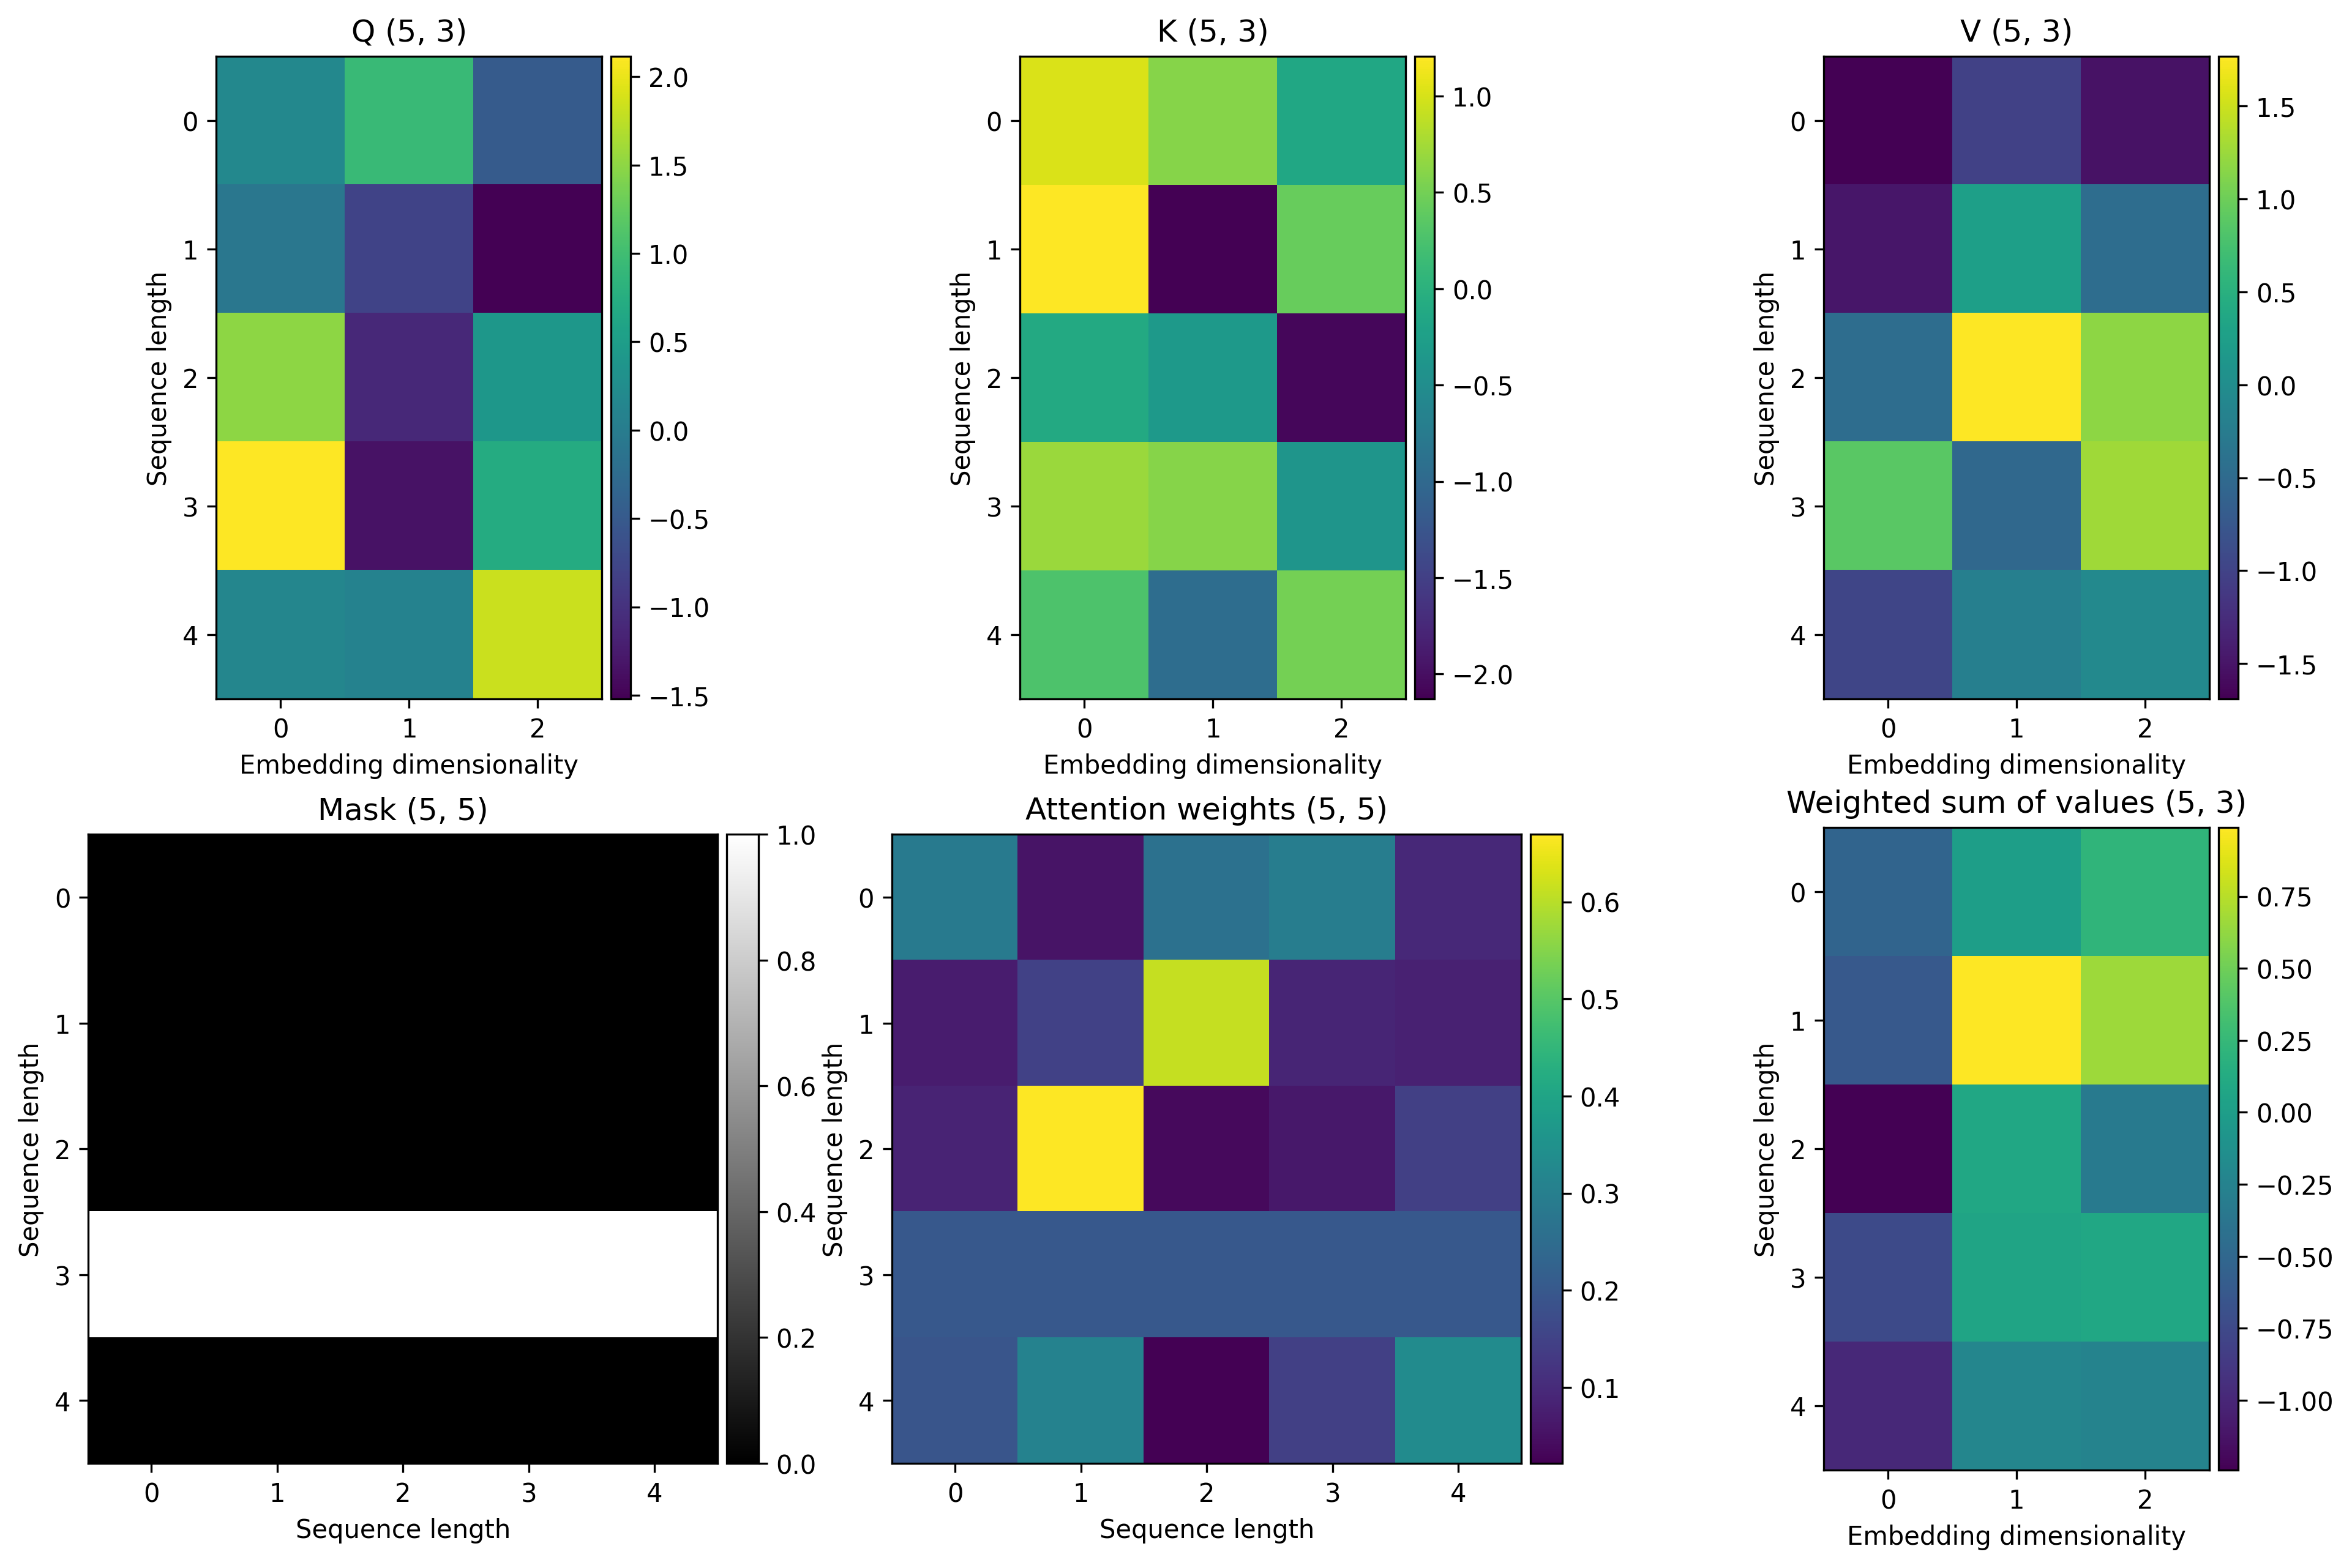

In [7]:
sequence_length = 5
embedding_dimensionality = 3

_, rand1 = random.split(main_rng)

qkv = random.normal(rand1, (3, sequence_length, embedding_dimensionality))
q, k, v = qkv[0], qkv[1], qkv[2]

mask = jnp.zeros((sequence_length, sequence_length))
mask = mask.at[3,:].set(1)

weighted_sum_of_values, attention_weights = scaled_dot_product(q, k, v, mask)
                 
display_scaled_dot_product(q, k, v, mask, weighted_sum_of_values, attention_weights)

# Multi-head attention

In [8]:
# Test
batch_size = 2
sequence_length = 13
embedding_dimensionality = 32
number_of_heads = 4

main_rng, x_rng = random.split(main_rng)

x = random.normal(x_rng, (batch_size, sequence_length, embedding_dimensionality))

mha = MultiheadAttention(embedding_dimensionality=embedding_dimensionality, number_of_heads=number_of_heads)

main_rng, init_rng = random.split(main_rng)

params = mha.init(init_rng, x)['params']
w_o, attention_weights = mha.apply({'params': params}, x)

print('Out', w_o.shape, 'Attention', attention_weights.shape)

del w_o, attention_weights

Out (2, 13, 32) Attention (2, 4, 13, 13)


# Transformer encoder

In [9]:
# Test
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))

encblock = EncoderBlock(input_dimensionality=128, number_of_heads=4, feedforward_dimensionality=512, dropout_probability=0.1)

main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = encblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']

main_rng, dropout_apply_rng = random.split(main_rng)
out = encblock.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del encblock, params

Out (3, 16, 128)


In [10]:
# Test
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))

transenc = TransformerEncoder(
    number_of_layers=5,
    input_dimensionality=128,
    number_of_heads=4,
    feedforward_dimensionality=256,
    dropout_probability=0.15)

main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transenc.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']

# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)

# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transenc.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)

attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transenc, binded_mod, params

Out (3, 16, 128)
Attention maps 5 (3, 4, 16, 16)


# Positional encoding

In [11]:
encod_block = PositionalEncoding(hidden_dimensionality=48, maximum_sequence_length=96).bind({})
positional_encoding = jax.device_get(encod_block.positional_encoding.squeeze().T)

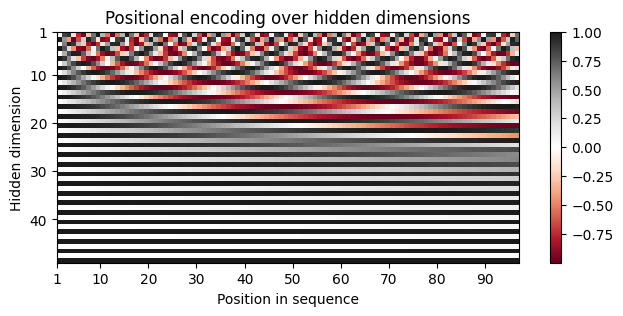

In [12]:
display_positional_encoding(positional_encoding)

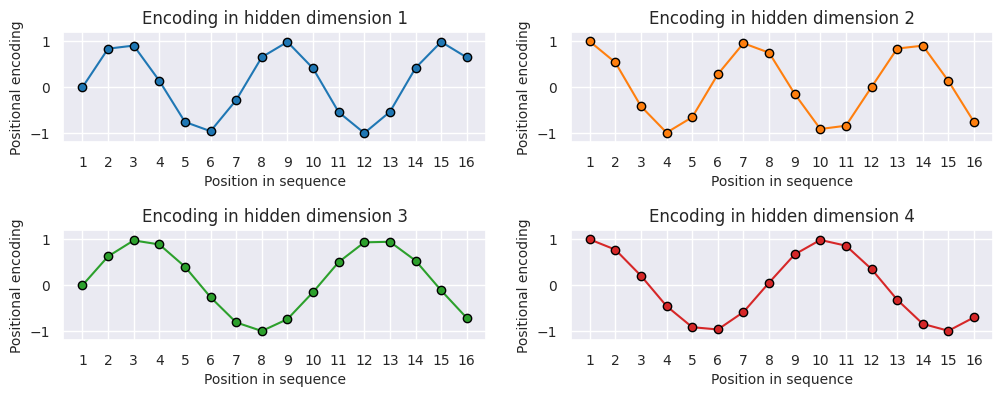

In [13]:
display_positional_encoding_profiles(positional_encoding)

In [14]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [15]:
def cosine_warmup_schedule(base_lr: float, warmup: int, max_iters: int):
    assert warmup > 0 and max_iters > 0
    # Create function to return lr based on iteration count
    def get_lr(train_iter):
        lr_factor = 0.5 * (1 + np.cos(np.pi * train_iter / max_iters))
        if train_iter <= warmup:
            lr_factor *= train_iter * 1.0 / warmup
        return lr_factor * base_lr
    return get_lr



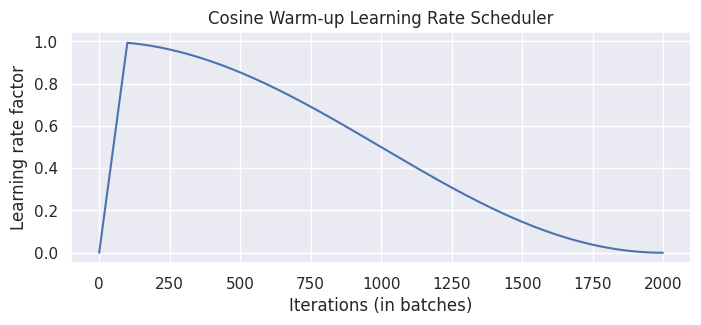

In [16]:
lr_scheduler = cosine_warmup_schedule(base_lr=1.0, warmup=100, max_iters=2000)

display_lr_scheduler(lr_scheduler)

# Full transformer model

In [17]:
main_rng, x_rng = random.split(main_rng)

x = random.normal(x_rng, (3, 16, 1))

transpre = TransformerPredictor(num_layers=5,
                                model_dim=128,
                                #num_classes=10,
                                num_heads=4,
                                dropout_prob=0.15,
                                input_dropout_prob=0.05)

# Initialize parameters of transformer predictor with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transpre.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']

print('[initialization finished]')

# Apply transformer predictor with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)

# Instead of passing params and rngs every time to a function call, we can bind them to the module
model = transpre.bind({'params': params}, rngs={'dropout': dropout_apply_rng})


out = model(x, mask=None, add_positional_encoding=True, train=True)
print('Out', out.shape)


attn_maps = model.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transpre, model, params

[initialization finished]
Out (3, 16, 128)
Attention maps 5 (3, 4, 16, 16)


# Trainer

In [18]:
class MLMDataset(data.Dataset):

    def __init__(self, np_rng):
        super().__init__()

        with open(os.path.join("..", "local_datasets", "wikipedia_man_o_war.pkl"), "rb") as fid:                                       
            self.dico_word2index, self.dico_index2word, self.dataset = pickle.load(fid) 
        
        self.num_categories = len(self.dico_word2index)
        self.maximum_sequence_length = len(self.dataset[0]["mask"])
        self.size = len(self.dataset)
        self.np_rng = np_rng

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        input_indices = self.dataset[index]["input_indices"]
        mask = self.dataset[index]["mask"]
        masked_indices = self.dataset[index]["masked_indices"]
        labels = self.dataset[index]["labels"]
        return input_indices, mask, masked_indices, labels

In [19]:
class Trainer(TrainerModule):

    def batch_to_input(self, batch):
        # [input_indices[], mask[], masked_indices[], labels[]]
        input_data = batch[0]            
        return input_data

    def get_loss_function(self):        
        def calculate_loss(params, rng, batch, train):
            input_data = np.array(batch[0])
            labels = batch[3]
            
            rng, dropout_apply_rng = random.split(rng)
            
            logits = self.model.apply({'params': params}, input_data, train=train, rngs={'dropout': dropout_apply_rng})
            print(logits.shape)
            
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            accuracy = (logits.argmax(axis=-1) == labels).mean()
            return loss, (accuracy, rng)
        return calculate_loss

In [20]:
def numpy_collate(batch):
    return np.array(batch)
    """
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)
    """

In [21]:
np_rng = np.random.default_rng(421)

dataset = MLMDataset(np_rng=np_rng)

data_loader_train = data.DataLoader(
    dataset,
    batch_size=9,
    shuffle=True,
    drop_last=True,
    collate_fn=numpy_collate)

data_loader_validation = data.DataLoader(
    dataset,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    collate_fn=numpy_collate)

data_loader_test = data.DataLoader(
    dataset,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    collate_fn=numpy_collate)

pc("Number of categories", dataset.num_categories)
pc("Maximum sequence length", dataset.maximum_sequence_length)
pc("Dataset size", dataset.size)

index = 7
input_indices, mask, masked_indices, labels = data_loader_train.dataset[index]

pc("Sequence length", len(input_indices))
pc("Input indices", input_indices)
pc("Mask", mask)
pc("Masked indices", masked_indices)
pc("Labels", labels)

Number of categories: 1099
Maximum sequence length: 50
Dataset size: 132
Sequence length: 50
Input indices: [  3  13  15  11  12  14 194   6   3  86 277 159   4 278  33 160  25   3
  56   6   3  78   5   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1]
Mask: [0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Masked indices: [  3  13  15   0  12  14 194   0   3  86 277 159   4   0   0 160  25   3
   0   6   0  78   5   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1]
Labels: [-100 -100 -100   11 -100 -100 -100    6 -100 -100 -100 -100 -100  278
   33 -100 -100 -100   56 -100    3 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100]


In [22]:
def do_training(max_epochs=10, **model_args):
    num_train_iters = len(data_loader_train) * max_epochs
    
    # Create a trainer module with specified hyperparameters
    trainer = Trainer(
        model_name='Trainer',
        exmp_batch=next(iter(data_loader_train)),
        max_iters=num_train_iters,
        checkpoint_path=CHECKPOINT_PATH,
        **model_args)

    if not trainer.checkpoint_exists():
        trainer.train_model(data_loader_train, data_loader_validation, num_epochs=max_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
        
    val_acc = trainer.eval_model(data_loader_validation)
    test_acc = trainer.eval_model(data_loader_test)
    
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'val_acc': val_acc, 'test_acc': test_acc}

In [23]:
reverse_trainer, reverse_result = do_training(
    model_dim=4,
    num_heads=2,                                                
    num_layers=3,
    dropout_prob=0.0,
    lr=5e-4,
    warmup=51)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/14 [00:00<?, ?it/s]

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape int32[4,50]
The error occurred while tracing the function train_step at /media/guillaume/DATA/NERD/GitHub/nlp/jax_transformer_mlm/trainer_module.py:58 for jit. This concrete value was not available in Python because it depends on the value of the argument batch.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [ ]:

u = [[  29   13   15   11   12    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1]
     
 [ 948  249  145    4  170  178  161  949  113    4  348  122  950  951
   952  953  954  428  184    3  429  430    6  147   97    5    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1]
     
 [ 866  867   35  149  383    9   88  407    6   34   49  868  869    9
   870  183   23  417  871  246    3  183  235  872  873  874  875   23
   876   35  156  184  133  244    4   23  246  877  235  878    5    1
     1    1    1    1    1    1    1    1]
     
 [ 811  812   32  813   20  182   88  407  237    6  182  814    9    3
    53    4  815    9    3  816   10  291    4   16  115   16  817    9
   206  818    5    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1]
     
 [ 118   81   90  649  650    4  651    4  652   17  123  221   72   86
   120  143  144   18    5    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1]
     
 [ 250   61  955  956    9    3  185    4   61  957    9  958    3  187
     6    3  959   17  960   97    4   40   32  249  245   10  384  145
     5    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1]
     
 [1059    4   10 1060 1061 1062  257  258    5  251   69   96    7 1063
  1064    9 1065    8  255    6  186    4  132    3 1066 1067    6   56
    97    7   37  140    4   35    3 1068  248   13   15   11   12   69
    96   25    3 1069  427   10  141 1070]
    
 [   3  223    7  222   32  674   28   45   54   95  119  373  232    3
    78    5    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1]
     
 [  45   54   95  119  348  222   23  223    5    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1]]

In [ ]:
u = [[1, 2], [3, 4]]

In [ ]:
print(u)
print(len(u))

In [ ]:
a = np.array(u, dtype="int32")

In [ ]:
print(a)

In [ ]:
print(a.shape)